In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
from os import listdir
from os.path import isfile, join
import io
import time

import glob

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

Using TensorFlow backend.


In [3]:
# Check if any duplicates are in the dataset 

In [4]:
# load data function
IMG_DIM = (150, 150)

dataset_path = os.getcwd()

def apply_permutation(data, indexes):
    n = len(data)
    result = np.empty(n, dtype=object)
    for i in range(n):
        result[i] = data[indexes[i]]
    return result

def load_dataset(data_type):
    path = join(dataset_path, data_type)
    files = []
    labels = []
    f_dir = [f for f in listdir(path) if not isfile(join(path, f))]

    for directory in f_dir:
        new_files = [join(path, directory, f) for f in listdir(join(path, directory)) if isfile(join(path, directory, f))]
        files.extend(new_files)
        for f in new_files:
            labels.append(directory)

    # shuffling data
    shuffled_indices = np.random.permutation(len(files))
    files = apply_permutation(files, shuffled_indices)
    labels = apply_permutation(labels, shuffled_indices)
    imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in files]
    imgs = np.array(imgs)

    return imgs, labels


In [5]:
imgs, labels = load_dataset('train')

train_imgs = imgs
train_labels = labels

imgs, labels = load_dataset('valid')
validation_imgs = imgs
validation_labels = labels

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)


23657 23657
875 875
Train dataset shape: (23657, 150, 150, 3) 	Validation dataset shape: (875, 150, 150, 3)


(150, 150, 3)


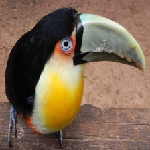

In [11]:
max_instances = 3000
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [12]:
batch_size = 30
num_classes = 175
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['YELLOW HEADED BLACKBIRD' 'VARIED THRUSH' 'PINK ROBIN' 'CRESTED CARACARA'
 'SAND MARTIN' 'WOOD DUCK' 'TRUMPTER SWAN' 'COUCHS KINGBIRD' 'PINK ROBIN'
 'TAIWAN MAGPIE'] [174 165 126  53 148 173 162  51 126 158]


In [8]:

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            

In [13]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 23657 samples, validate on 875 samples
Epoch 1/30
23657/23657 [==============================] - 1031s 44ms/step - loss: -98688341405659.0469 - accuracy: 0.0070 - val_loss: -533024252623398.1250 - val_accuracy: 0.0057
Epoch 2/30
23657/23657 [==============================] - 998s 42ms/step - loss: -4472330854206444.5000 - accuracy: 0.0070 - val_loss: -12718689831920600.0000 - val_accuracy: 0.0057
Epoch 3/30
10440/23657 [============>.................] - ETA: 8:54 - loss: -21605502344097368.0000 - accuracy: 0.0069

KeyboardInterrupt: 

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

NameError: name 'history' is not defined